# Compare the CIGALE results of EMU and non-EMU sources

In [ ]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import math


# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
# Use the Planck 2020/2018 cosmology
from astropy.cosmology import Planck18 as cosmo

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn
import seaborn as sns

## Import results files from EMU and non-EMU sources and select objects with x²_red < 5

In [4]:
emu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/emu_data/out_withAGN/results.txt', sep='\s+')
nonemu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/cigale_redshifts/results.txt', sep='\s+')
# nonemu_prototypes = 

Select EMU and non-EMU sources with a x²_red less than 5 , to analyse sources with a good fitting.

In [5]:
best_matches_emu = emu_sources['best.reduced_chi_square'] <= 5.0
emu_sources_best = emu_sources[best_matches_emu]
print(f'Number of emu objects with x²_red <= 5: {len(emu_sources_best)}')


best_matches_nonemu = nonemu_sources['best.reduced_chi_square'] <= 5.0
nonemu_sources_best = nonemu_sources[best_matches_nonemu]
print(f'Number of non-emu objects with x²_red <= 5: {len(nonemu_sources_best)}')

Number of emu objects with x²_red <= 5: 3497
Number of non-emu objects with x²_red <= 5: 3032


## Compare EMU and non-EMU sources

### Histogram of EMU and non-EMU sources

In [14]:
def plot_log_hist_percent_2rows_sns(
    df1, df2, columns, x_labels, legend_positions, 
    labels=("DF1", "DF2"), figsize=(15, 8), bins=50
):
    """
    Plot histograms with y-axis as percentage of total sources for two DataFrames in 2 rows.
    Includes vertical lines for mean values. Uses log scaling on x-axis where appropriate.

    Parameters:
    - df1, df2: pandas DataFrames
    - columns: list of column names to plot (must exist in both)
    - x_labels: list of x-axis labels (same length as columns)
    - legend_positions: list of legend positions per subplot
    - labels: tuple of legend labels for df1 and df2
    - figsize: tuple for figure size
    - bins: number of bins or sequence of bin edges
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.agn.fracAGN' in col:
            # Linear scale
            ax.hist(
                data1,
                bins=bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            # Means
            ax.axvline(data1.mean(), color='blue', linestyle='dashed', linewidth=1.5, label=f"{labels[0]} Mean")
            ax.axvline(data2.mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"{labels[1]} Mean")

        else:
            # Log scale
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            min_val = min(data1.min(), data2.min())
            max_val = max(data1.max(), data2.max())
            log_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

            ax.hist(
                data1,
                bins=log_bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=log_bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            ax.set_xscale('log')
            ax.set_xlabel(x_labels[i] + " (log scale)")

            # Means (log scale plots)
            ax.axvline(data1.mean(), color='blue', linestyle='dashed', linewidth=1.5, label=f"{labels[0]} Mean")
            ax.axvline(data2.mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"{labels[1]} Mean")

        ax.set_title(col)
        ax.set_ylabel('Percentage of Sources [%]')
        ax.legend(loc=legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

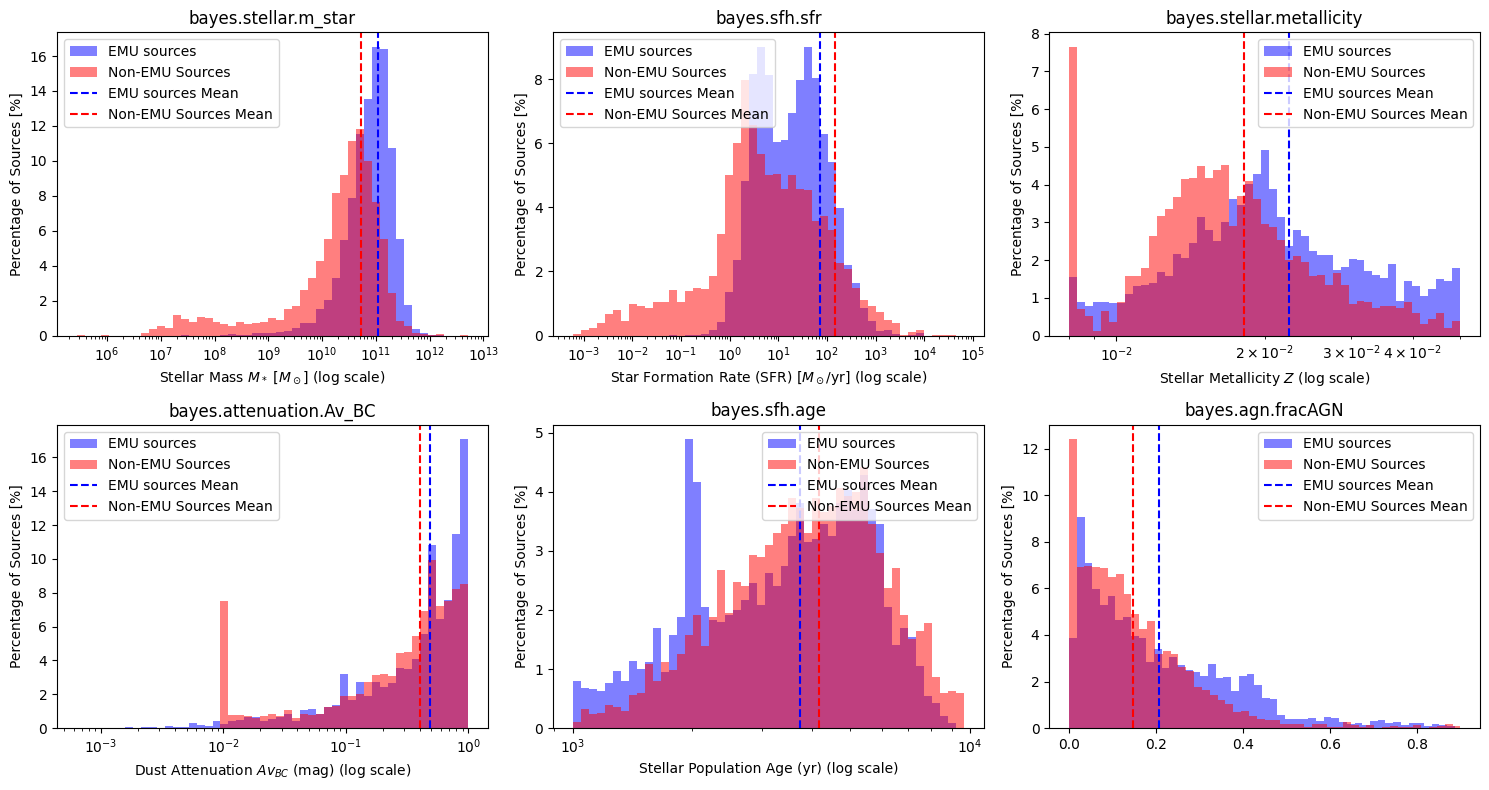

In [15]:
legend_positions = [
    'upper left', 
    'upper left',   
    'upper right',           
    'upper left',         
    'upper right',
    'upper right' 
]



plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ [$M_\odot$]",
        r"Star Formation Rate (SFR) [$M_\odot$/yr]",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction"
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions=legend_positions
)

### Density plot of EMU and non-EMU sources

In [44]:
def plot_log_kde_2rows_sns(df1, df2, columns, x_labels, legend_positions, labels=("DF1", "DF2"), figsize=(15, 8)):
    """
    Plot KDE (density) curves using Seaborn for specified columns from two DataFrames in 2 rows.
    Uses log scaling on axes where appropriate.

    Parameters:
    - df1, df2: pandas DataFrames
    - columns: list of column names to plot (must exist in both)
    - x_labels: list of x-axis labels (same length as columns)
    - labels: tuple of legend labels for df1 and df2
    - figsize: tuple for figure size
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.agn.fracAGN' in col:
            # Linear scale
            sns.kdeplot(data1, ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
        else:
            # Log scale (filter > 0)
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            sns.kdeplot(np.log10(data1), ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(np.log10(data2), ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
            ax.set_xlabel(x_labels[i] + " (log₁₀)")
            ax.set_xticks(np.arange(np.floor(np.log10(data1.min())), np.ceil(np.log10(data1.max())) + 1))
            ax.set_xticklabels([f"$10^{int(x)}$" for x in ax.get_xticks()])
            ax.set_xlim(left=np.log10(min(data1.min(), data2.min())))

        ax.set_title(col)
        ax.set_ylabel('Density')
        ax.legend(loc = legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

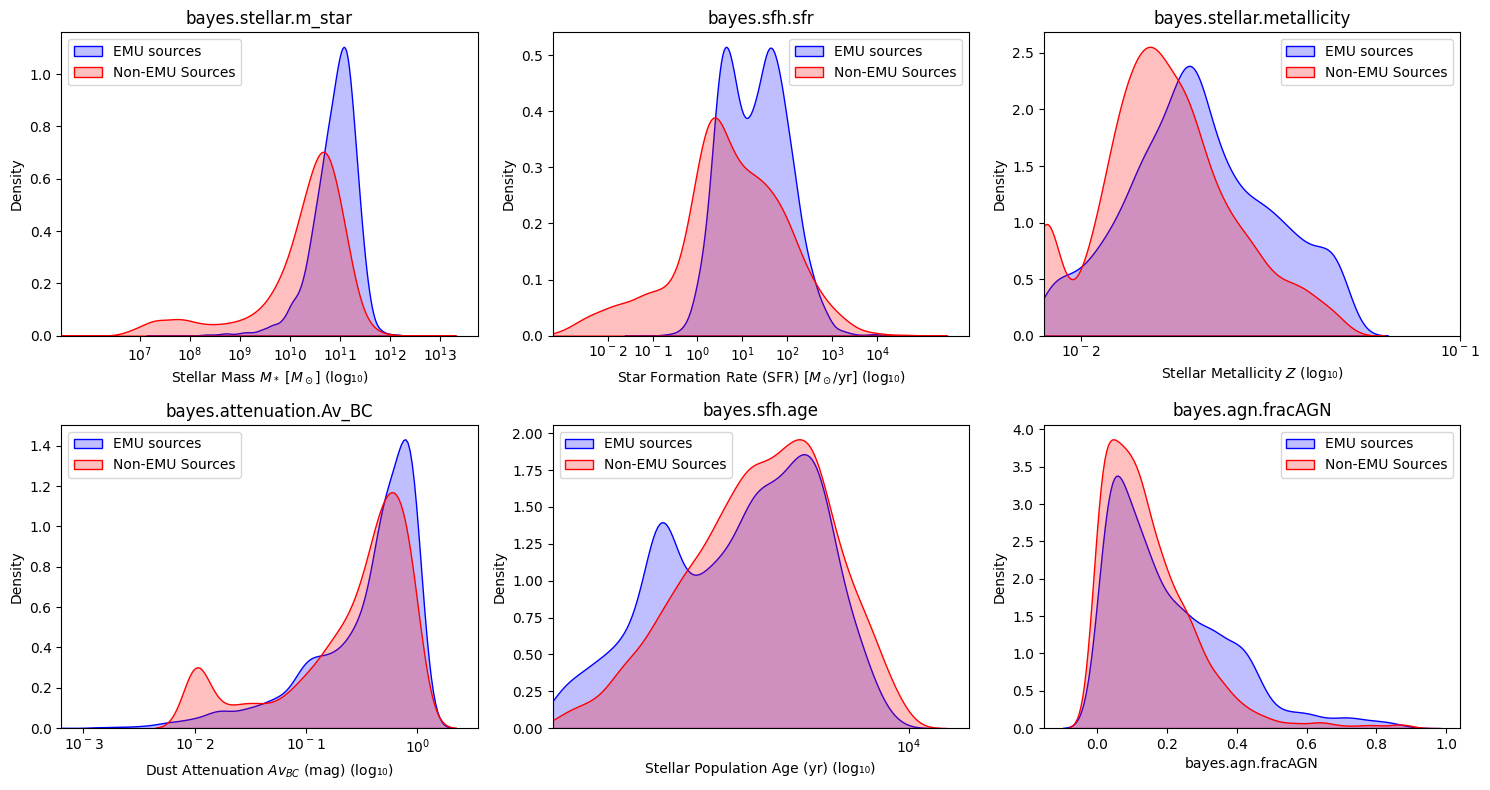

In [47]:
legend_positions = [
    'upper left', 
    'upper right',   
    'upper right',           
    'upper left',         
    'upper left',
    'upper right' 
]



plot_log_kde_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ [$M_\odot$]",
        r"Star Formation Rate (SFR) [$M_\odot$/yr]",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction"
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions=legend_positions
)